In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For image processing and visualization
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
import PIL.Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


from keras import backend as K
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image

from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import optimizers
print(" All libraries imported successfully")

 All libraries imported successfully


In [ ]:

!pip install -q kaggle

!mkdir -p ~/.kaggle

from google.colab import files
files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c state-farm-distracted-driver-detection
#
!unzip -q state-farm-distracted-driver-detection.zip -d data

!ls data

Saving kaggle.json to kaggle.json
 99% 3.96G/4.00G [01:43<00:00, 141MB/s]
100% 4.00G/4.00G [01:43<00:00, 41.4MB/s]
driver_imgs_list.csv  imgs  sample_submission.csv


#### 224x224 image size: Standard input size for popular CNN architectures like ResNet, VGG, EfficientNet
#### Batch size of 32: Good balance between memory usage and training stability
#### Class mapping: Clear understanding of what each class represents for better model interpretation

In [ ]:
# Dataset paths
TRAIN_DIR = '/content/data/imgs/train'
TEST_DIR = '/content/data/imgs/test'
DRIVER_IMGS_LIST = '/content/data/driver_imgs_list.csv'

# Image parameters
IMG_SIZE = (224, 224)  # Standard size for most CNN architectures
BATCH_SIZE = 32

# Class labels
CLASS_NAMES = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
CLASS_DESCRIPTIONS = {
    'c0': 'Safe driving',
    'c1': 'Texting - right',
    'c2': 'Talking on phone - right',
    'c3': 'Texting - left',
    'c4': 'Talking on phone - left',
    'c5': 'Operating the radio',
    'c6': 'Drinking',
    'c7': 'Reaching behind',
    'c8': 'Hair and makeup',
    'c9': 'Talking to passenger'
}

print("Dataset paths configured successfully!")
print(f"Target image size: {IMG_SIZE}")
print(f"Number of classes: {len(CLASS_NAMES)}")

Dataset paths configured successfully!
Target image size: (224, 224)
Number of classes: 10


Understanding the dataset structure is crucial before preprocessing
Knowing the number of unique drivers helps in creating proper train/validation splits
This prevents data leakage (same driver appearing in both train and validation sets)

In [ ]:
# Load the driver images list
df_drivers = pd.read_csv(DRIVER_IMGS_LIST)

print("Driver Images Dataset Info:")
print(f"Total images: {len(df_drivers)}")
print(f"Columns: {df_drivers.columns.tolist()}")
print("\nFirst few rows:")
print(df_drivers.head())

# Check unique drivers and classes
print(f"\nUnique drivers: {df_drivers['subject'].nunique()}")
print(f"Unique classes: {df_drivers['classname'].nunique()}")

# Display basic statistics
print(f"\nDataset Statistics:")
print(df_drivers.describe(include='all'))

Driver Images Dataset Info:
Total images: 22424
Columns: ['subject', 'classname', 'img']

First few rows:
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Unique drivers: 26
Unique classes: 10

Dataset Statistics:
       subject classname           img
count    22424     22424         22424
unique      26        10         22424
top       p021        c0  img_9684.jpg
freq      1237      2489             1


Class imbalance detection: Helps identify if any classes are underrepresented
Data distribution understanding: Critical for choosing appropriate sampling strategies
Driver distribution: Ensures we understand how data is distributed across different subjects
Planning data augmentation: Underrepresented classes might need more augmentation

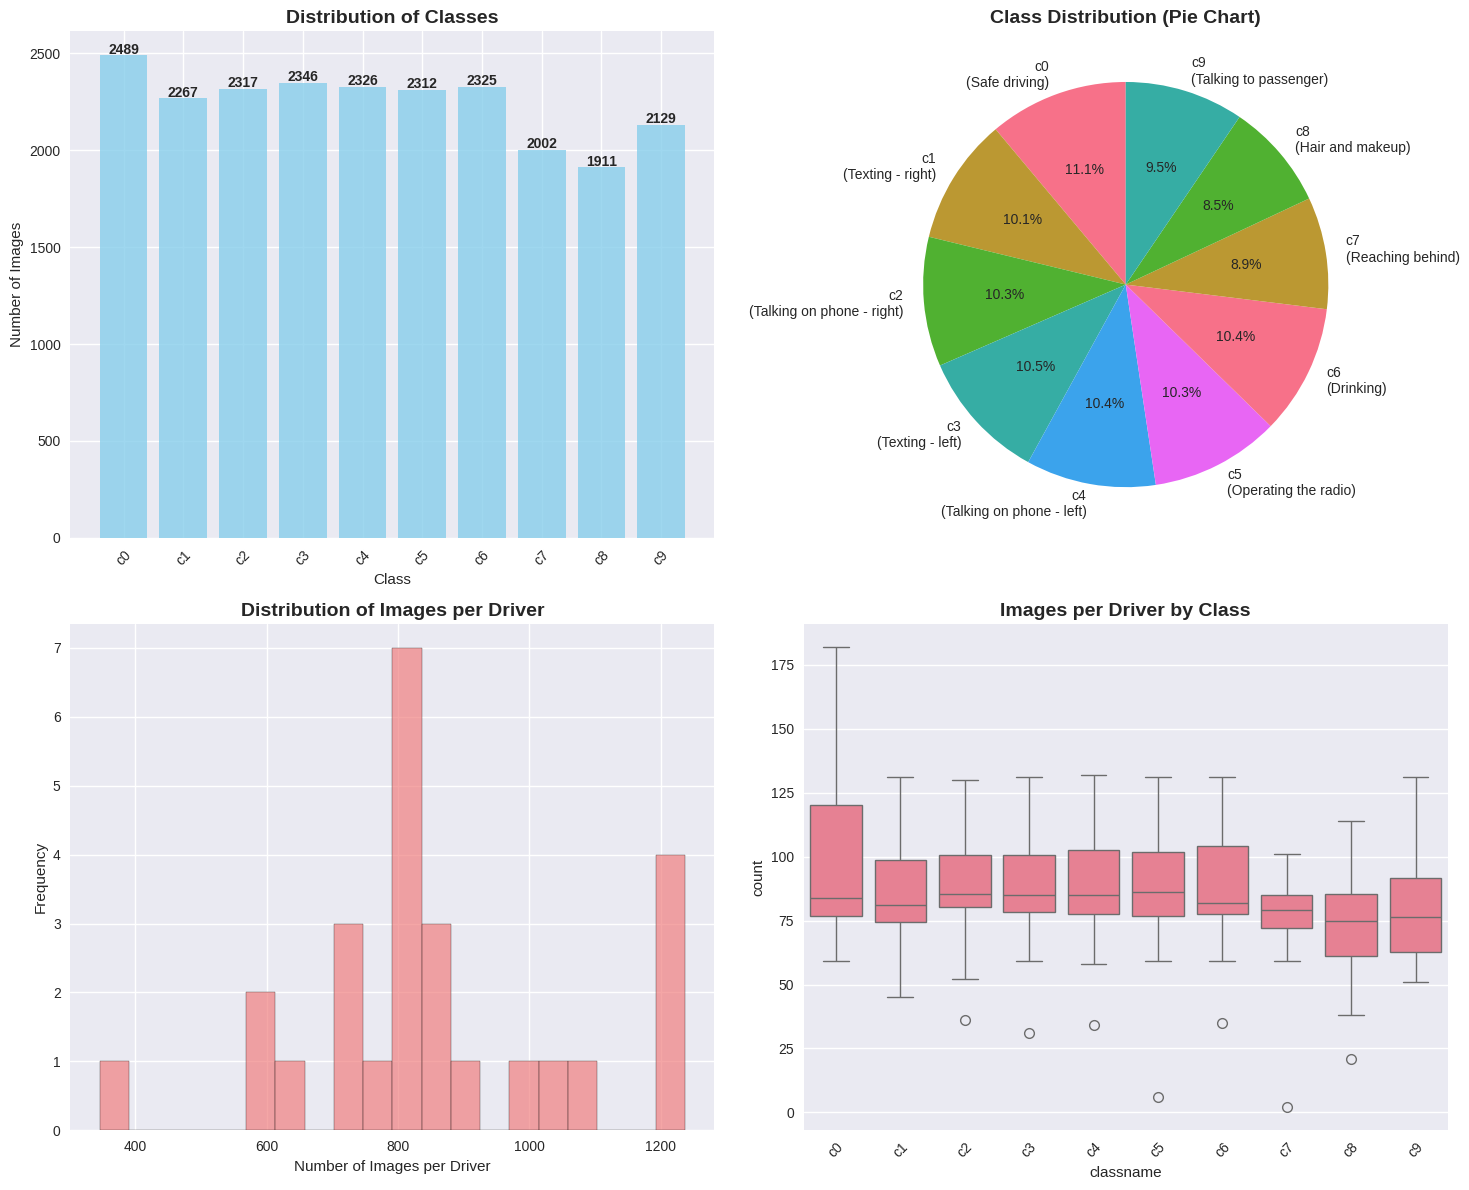

Class Distribution Analysis:
Most common class: c0 (Safe driving) - 2489 images
Least common class: c9 (Talking to passenger) - 2129 images
Average images per class: 2242.4
Standard deviation: 175.4


In [ ]:
# Class distribution analysis
class_counts = df_drivers['classname'].value_counts().sort_index()

# Create subplot for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bar plot of class distribution
axes[0,0].bar(class_counts.index, class_counts.values, color='skyblue', alpha=0.8)
axes[0,0].set_title('Distribution of Classes', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Number of Images')
axes[0,0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    axes[0,0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart for class distribution
axes[0,1].pie(class_counts.values, labels=[f'{cls}\n({CLASS_DESCRIPTIONS[cls]})' for cls in class_counts.index],
             autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')

# Driver distribution
driver_counts = df_drivers['subject'].value_counts()
axes[1,0].hist(driver_counts.values, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribution of Images per Driver', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Number of Images per Driver')
axes[1,0].set_ylabel('Frequency')

# Box plot for images per driver by class
df_driver_class = df_drivers.groupby(['subject', 'classname']).size().reset_index(name='count')
sns.boxplot(data=df_driver_class, x='classname', y='count', ax=axes[1,1])
axes[1,1].set_title('Images per Driver by Class', fontsize=14, fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Class Distribution Analysis:")
print(f"Most common class: {class_counts.index[0]} ({CLASS_DESCRIPTIONS[class_counts.index[0]]}) - {class_counts.iloc[0]} images")
print(f"Least common class: {class_counts.index[-1]} ({CLASS_DESCRIPTIONS[class_counts.index[-1]]}) - {class_counts.iloc[-1]} images")
print(f"Average images per class: {class_counts.mean():.1f}")
print(f"Standard deviation: {class_counts.std():.1f}")

Visual understanding: See what each class actually looks like
Quality assessment: Check for image quality, lighting conditions, angles
Preprocessing planning: Identify what preprocessing steps might be needed
Data validation: Ensure images are correctly labeled

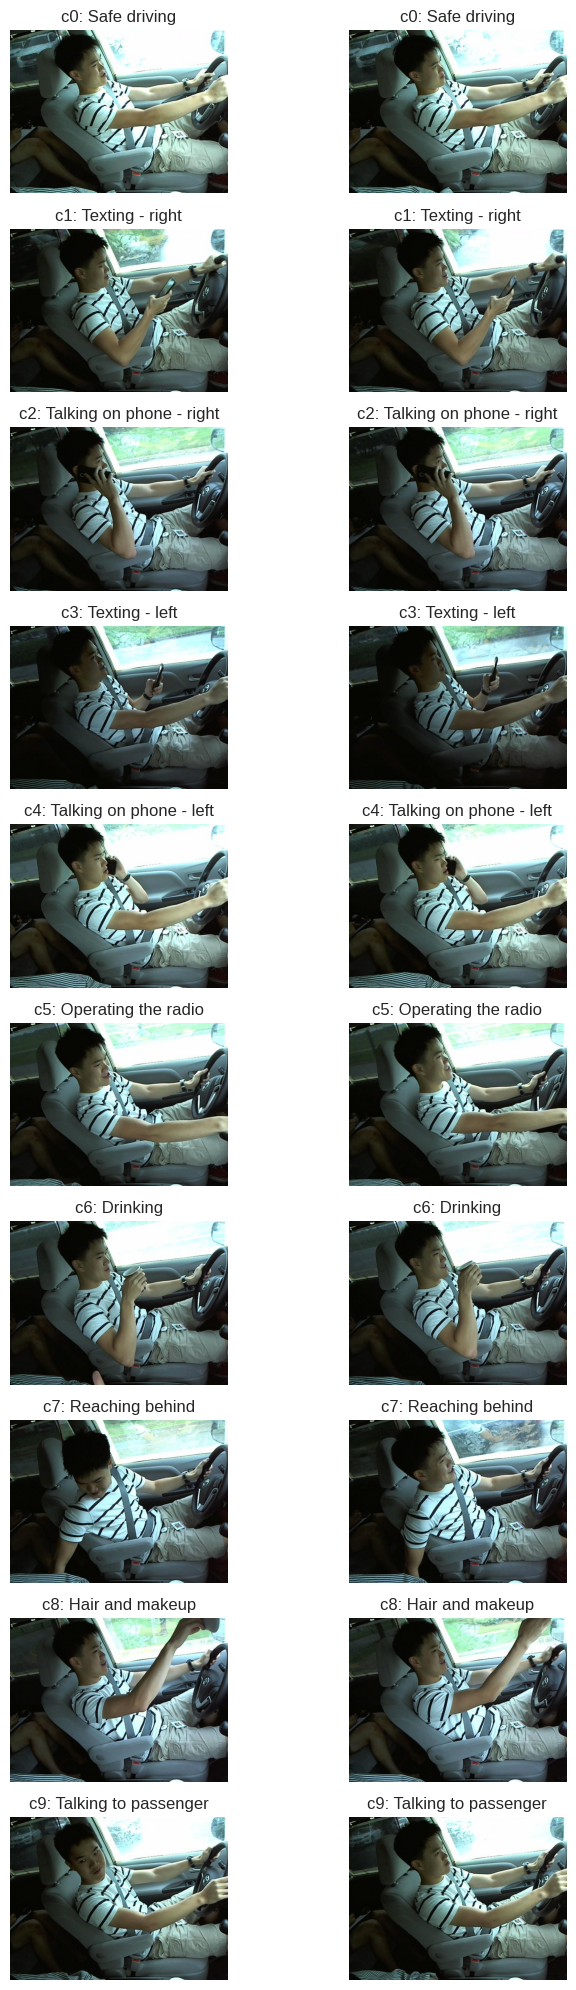

In [ ]:
def load_and_display_samples(num_samples=2):
    """Load and display sample images from each class"""

    fig, axes = plt.subplots(len(CLASS_NAMES), num_samples, figsize=(8, 20))

    for class_idx, class_name in enumerate(CLASS_NAMES):
        # Get sample images from this class
        class_images = df_drivers[df_drivers['classname'] == class_name]['img'].values[:num_samples]

        for img_idx, img_name in enumerate(class_images):
            img_path = os.path.join(TRAIN_DIR, class_name, img_name)

            # Load and display image
            try:
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[class_idx, img_idx].imshow(img_rgb)
                axes[class_idx, img_idx].set_title(f'{class_name}: {CLASS_DESCRIPTIONS[class_name]}')
                axes[class_idx, img_idx].axis('off')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                axes[class_idx, img_idx].text(0.5, 0.5, 'Image\nNot Found',
                                            ha='center', va='center', transform=axes[class_idx, img_idx].transAxes)
                axes[class_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Display samples
load_and_display_samples()

Standardization needs: Understanding dimension variations helps decide on resize strategy
Memory planning: File size analysis helps estimate memory requirements
Preprocessing decisions: Knowing common dimensions helps choose optimal target size
Quality control: Identifies outliers or corrupted images

Analyzing properties of 500 images...
Error processing /content/data/imgs/train/c2/img_74799.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c5/img_34810.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c6/img_99256.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c0/img_89684.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c9/img_46424.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c1/img_21293.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c1/img_3744.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c9/img_4588.jpg: type object 'Image' has no attribute 'open'
Error processing /content/data/imgs/train/c3/img_24714.jpg: type object 'Image' has no attribute 'open'
Error processing /content/da

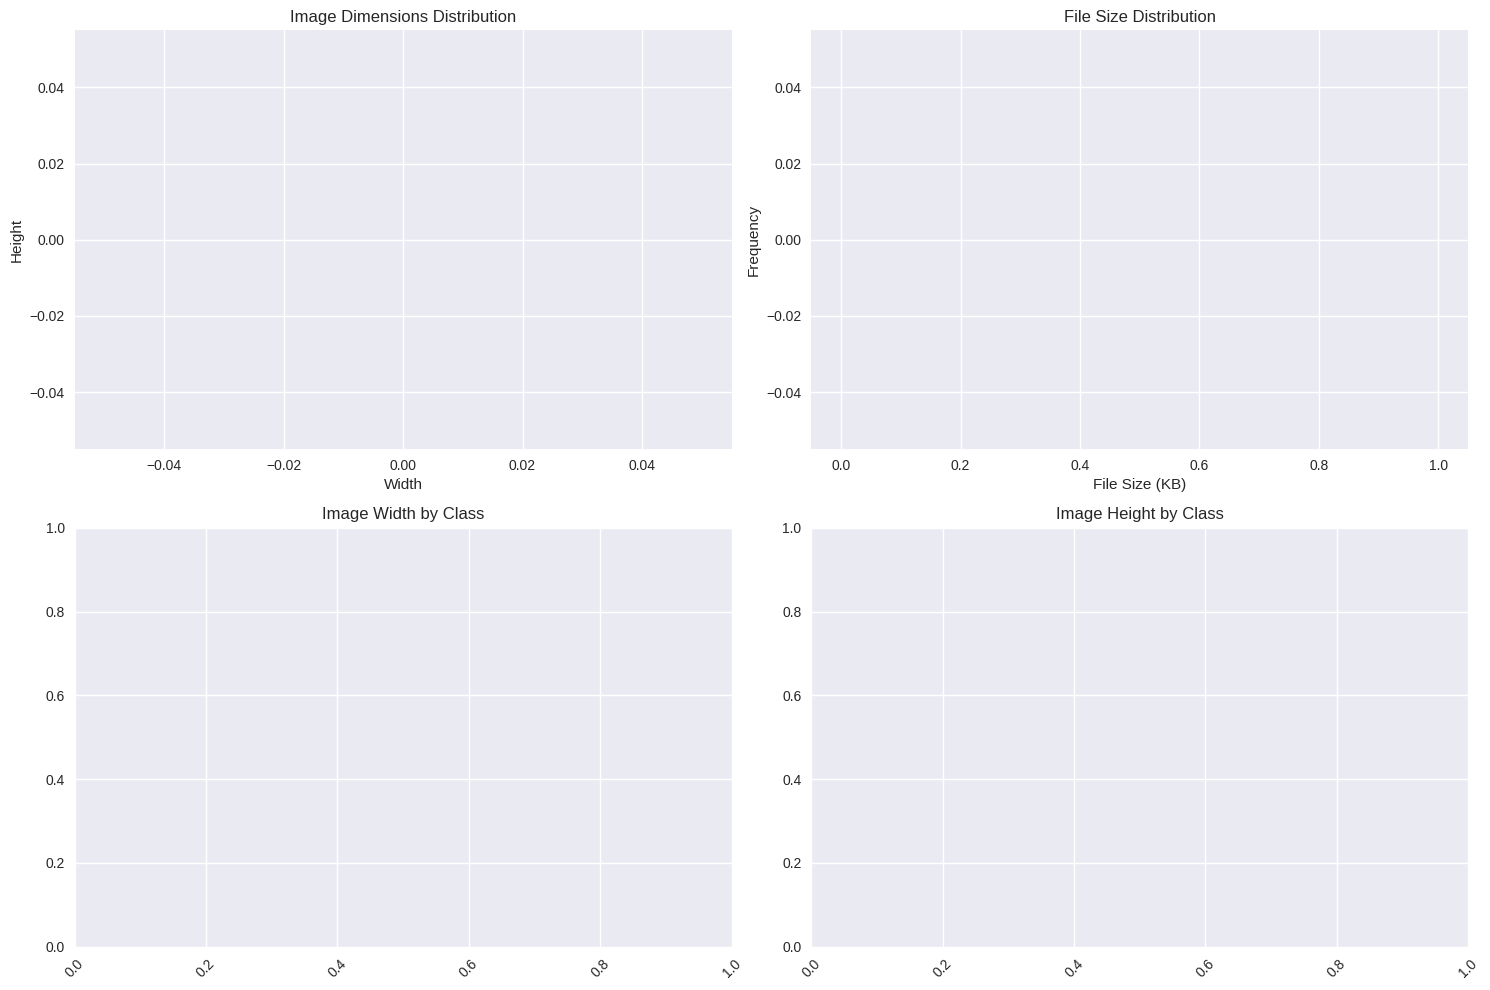

Image Properties Analysis:
Average width: nan pixels
Average height: nan pixels
Average file size: nan KB


In [ ]:
def analyze_image_properties(sample_size=500):
    """Analyze image properties like dimensions, channels, file sizes"""

    image_properties = {
        'width': [],
        'height': [],
        'channels': [],
        'file_size': [],
        'class': []
    }

    # Sample images from dataset
    sample_df = df_drivers.sample(n=min(sample_size, len(df_drivers)), random_state=42)

    print(f"Analyzing properties of {len(sample_df)} images...")

    for _, row in sample_df.iterrows():
        img_path = os.path.join(TRAIN_DIR, row['classname'], row['img'])

        try:
            # Load image with PIL for better property analysis
            with Image.open(img_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                file_size = os.path.getsize(img_path) / 1024  # KB

                image_properties['width'].append(width)
                image_properties['height'].append(height)
                image_properties['channels'].append(channels)
                image_properties['file_size'].append(file_size)
                image_properties['class'].append(row['classname'])

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame for analysis
    props_df = pd.DataFrame(image_properties)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Image dimensions scatter plot
    scatter = axes[0,0].scatter(props_df['width'], props_df['height'],
                              c=props_df['class'].astype('category').cat.codes,
                              alpha=0.6, cmap='tab10')
    axes[0,0].set_xlabel('Width')
    axes[0,0].set_ylabel('Height')
    axes[0,0].set_title('Image Dimensions Distribution')

    # File size distribution
    axes[0,1].hist(props_df['file_size'], bins=30, alpha=0.7, color='lightgreen')
    axes[0,1].set_xlabel('File Size (KB)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('File Size Distribution')

    # Dimensions by class
    sns.boxplot(data=props_df, x='class', y='width', ax=axes[1,0])
    axes[1,0].set_title('Image Width by Class')
    axes[1,0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=props_df, x='class', y='height', ax=axes[1,1])
    axes[1,1].set_title('Image Height by Class')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Image Properties Analysis:")
    print(f"Average width: {props_df['width'].mean():.1f} pixels")
    print(f"Average height: {props_df['height'].mean():.1f} pixels")
    print(f"Average file size: {props_df['file_size'].mean():.1f} KB")

    if len(props_df) > 0:
        most_common_dims = props_df.groupby(['width', 'height']).size().idxmax()
        print(f"Most common dimensions: {most_common_dims}")

    return props_df

# Run image properties analysis
props_df = analyze_image_properties()

Prevents data leakage: Same driver never appears in both train and validation
Real-world simulation: Model must generalize to completely new drivers
Driver-level split: More realistic evaluation of model performance
Class distribution awareness: Monitors how split affects class balance

Data Split Analysis:
Total drivers: 26
Training drivers: 20
Validation drivers: 6

Training images: 17446
Validation images: 4978


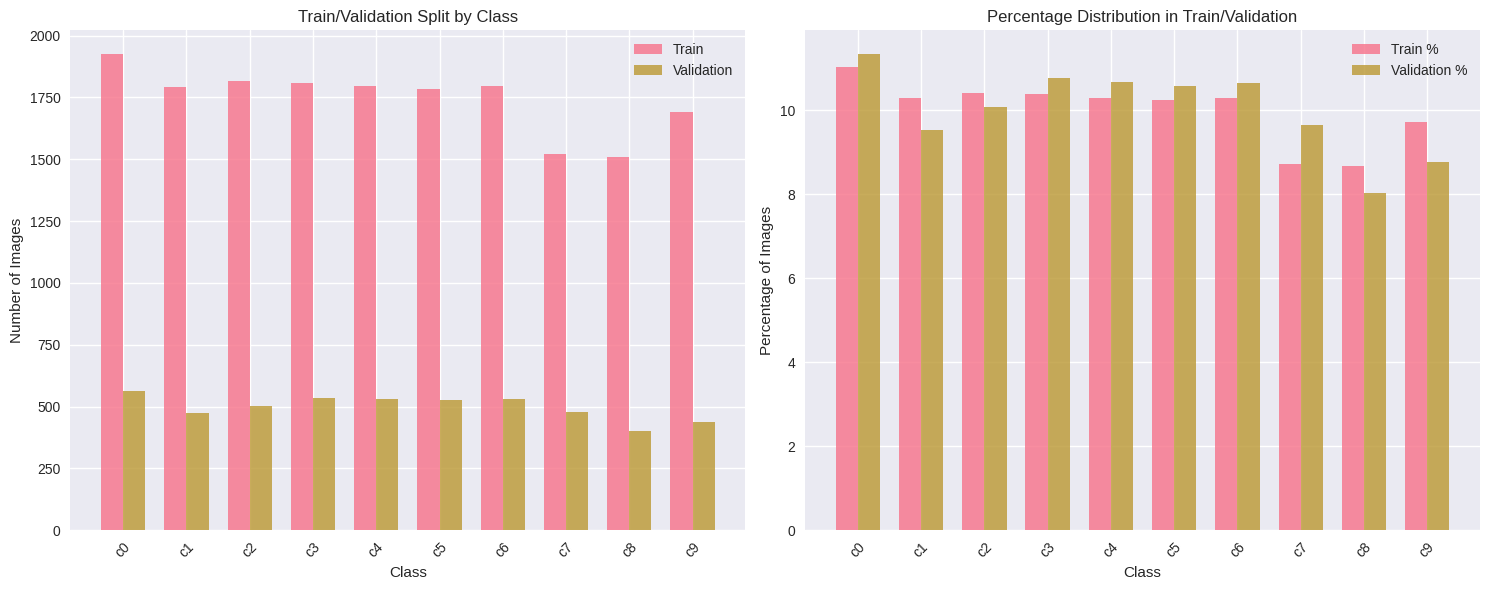

In [ ]:
def create_train_val_split(test_size=0.2, random_state=42):
    """
    Create train/validation split ensuring no driver appears in both sets
    """

    # Get unique drivers
    unique_drivers = df_drivers['subject'].unique()

    # Split drivers (not images) to prevent data leakage
    train_drivers, val_drivers = train_test_split(
        unique_drivers,
        test_size=test_size,
        random_state=random_state,
        stratify=None  # We can't stratify by class at driver level
    )

    # Create train and validation dataframes
    train_df = df_drivers[df_drivers['subject'].isin(train_drivers)]
    val_df = df_drivers[df_drivers['subject'].isin(val_drivers)]

    print("Data Split Analysis:")
    print(f"Total drivers: {len(unique_drivers)}")
    print(f"Training drivers: {len(train_drivers)}")
    print(f"Validation drivers: {len(val_drivers)}")
    print(f"\nTraining images: {len(train_df)}")
    print(f"Validation images: {len(val_df)}")

    # Analyze class distribution in splits
    train_class_dist = train_df['classname'].value_counts().sort_index()
    val_class_dist = val_df['classname'].value_counts().sort_index()

    # Visualization of split
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    x = np.arange(len(CLASS_NAMES))
    width = 0.35

    axes[0].bar(x - width/2, train_class_dist.values, width, label='Train', alpha=0.8)
    axes[0].bar(x + width/2, val_class_dist.values, width, label='Validation', alpha=0.8)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].set_title('Train/Validation Split by Class')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(CLASS_NAMES, rotation=45)
    axes[0].legend()

    # Percentage distribution
    train_pct = (train_class_dist / train_class_dist.sum()) * 100
    val_pct = (val_class_dist / val_class_dist.sum()) * 100

    axes[1].bar(x - width/2, train_pct.values, width, label='Train %', alpha=0.8)
    axes[1].bar(x + width/2, val_pct.values, width, label='Validation %', alpha=0.8)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Percentage of Images')
    axes[1].set_title('Percentage Distribution in Train/Validation')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(CLASS_NAMES, rotation=45)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return train_df, val_df, train_drivers, val_drivers

# Create the split
train_df, val_df, train_drivers, val_drivers = create_train_val_split()

Resizing: Standardizes input size for neural networks
Normalization: Scales pixel values to [0,1] range for better training stability
Color space conversion: Ensures consistent RGB format
Error handling: Robust preprocessing that handles potential issues

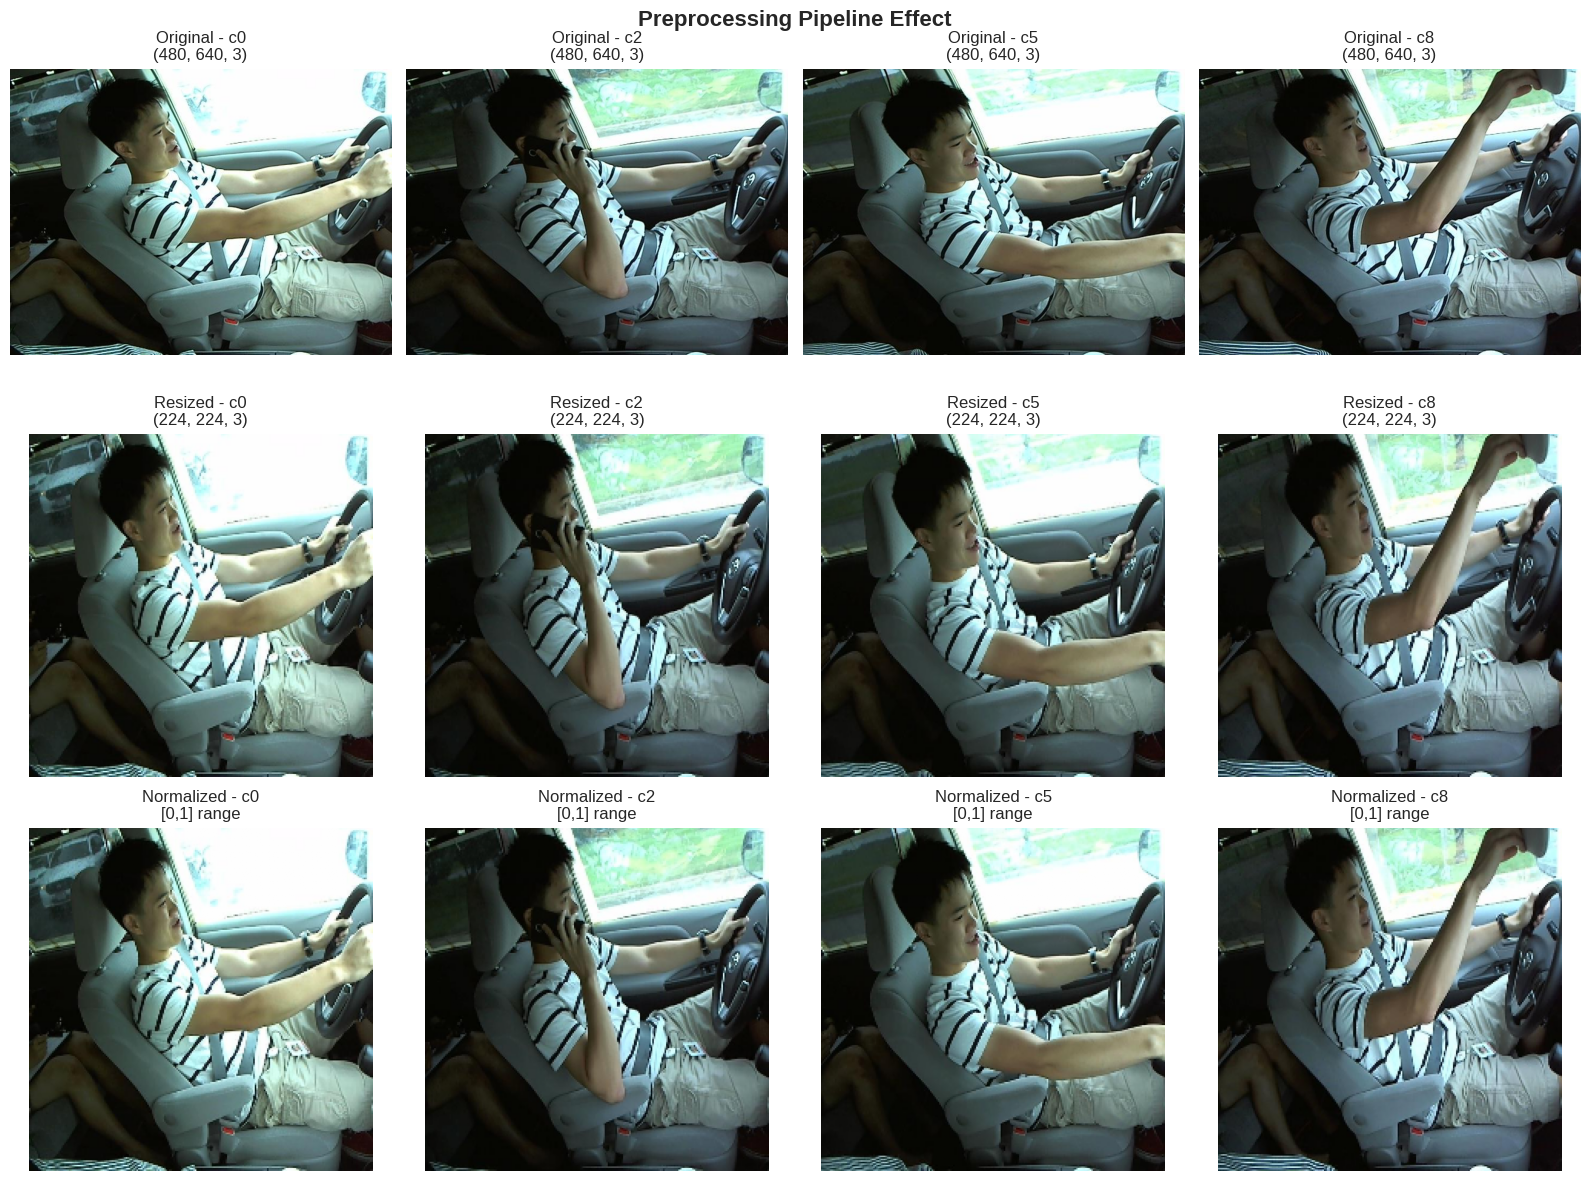

In [ ]:
def preprocess_image(image_path, target_size=IMG_SIZE, normalize=True):
    """
    Preprocess a single image for model training
    """
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            return None

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize image
        image = cv2.resize(image, target_size)

        # Convert to float and normalize
        if normalize:
            image = image.astype('float32') / 255.0

        return image

    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None

def show_preprocessing_effect():
    """Demonstrate the effect of preprocessing on sample images"""

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))

    # Select sample images from different classes
    sample_classes = ['c0', 'c2', 'c5', 'c8']

    for i, class_name in enumerate(sample_classes):
        # Get a sample image from this class
        class_images = df_drivers[df_drivers['classname'] == class_name]
        if len(class_images) > 0:
            sample_img = class_images.iloc[0]['img']
            img_path = os.path.join(TRAIN_DIR, class_name, sample_img)

            try:
                # Original image
                original = cv2.imread(img_path)
                original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

                # Resized image
                resized = cv2.resize(original_rgb, IMG_SIZE)

                # Normalized image
                normalized = resized.astype('float32') / 255.0

                # Display all versions
                axes[0, i].imshow(original_rgb)
                axes[0, i].set_title(f'Original - {class_name}\n{original_rgb.shape}')
                axes[0, i].axis('off')

                axes[1, i].imshow(resized)
                axes[1, i].set_title(f'Resized - {class_name}\n{resized.shape}')
                axes[1, i].axis('off')

                axes[2, i].imshow(normalized)
                axes[2, i].set_title(f'Normalized - {class_name}\n[0,1] range')
                axes[2, i].axis('off')

            except Exception as e:
                print(f"Error processing {class_name}: {e}")
                for row in range(3):
                    axes[row, i].text(0.5, 0.5, f'Error\n{class_name}',
                                    ha='center', va='center', transform=axes[row, i].transAxes)
                    axes[row, i].axis('off')

    plt.suptitle('Preprocessing Pipeline Effect', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Demonstrate preprocessing
show_preprocessing_effect()

Memory management: Prevents out-of-memory errors
Training efficiency: Faster data loading improves training speed
Scalability: Allows training on larger datasets
Resource utilization: Maximizes hardware efficiency

In [ ]:
def estimate_memory_requirements():
    """Estimate memory requirements for different batch sizes"""

    # Image dimensions
    height, width, channels = IMG_SIZE[0], IMG_SIZE[1], 3

    # Memory per image (in MB)
    memory_per_image = (height * width * channels * 4) / (1024**2)  # 4 bytes for float32

    batch_sizes = [16, 32, 64, 128]

    print("Memory Requirements Estimation:")
    print("-" * 50)
    for batch_size in batch_sizes:
        batch_memory = memory_per_image * batch_size
        print(f"Batch size {batch_size:3d}: {batch_memory:.2f} MB per batch")

    print(f"\nMemory per image: {memory_per_image:.4f} MB")
    print(f"Total training images: {len(train_df)}")
    print(f"Total validation images: {len(val_df)}")

    # Estimate total memory for full dataset
    total_train_memory = memory_per_image * len(train_df)
    total_val_memory = memory_per_image * len(val_df)

    print(f"\nFull dataset memory requirements:")
    print(f"Training set: {total_train_memory:.2f} MB ({total_train_memory/1024:.2f} GB)")
    print(f"Validation set: {total_val_memory:.2f} MB ({total_val_memory/1024:.2f} GB)")
    print(f"Total: {(total_train_memory + total_val_memory)/1024:.2f} GB")

estimate_memory_requirements()

Memory Requirements Estimation:
--------------------------------------------------
Batch size  16: 9.19 MB per batch
Batch size  32: 18.38 MB per batch
Batch size  64: 36.75 MB per batch
Batch size 128: 73.50 MB per batch

Memory per image: 0.5742 MB
Total training images: 17446
Total validation images: 4978

Full dataset memory requirements:
Training set: 10017.82 MB (9.78 GB)
Validation set: 2858.46 MB (2.79 GB)
Total: 12.57 GB


In [ ]:
def assess_data_readiness():
    """Assess if the dataset is ready for model building"""

    print(" Dataset Readiness Assessment for Model Building")
    print("=" * 60)

    readiness_checks = {
        'Data Loading': False,
        'Class Balance': False,
        'Image Quality': False,
        'Train/Val Split': False,
        'Preprocessing Ready': False,
        'Memory Feasible': False
    }

    # Check 1: Data Loading
    try:
        sample_img_path = os.path.join(TRAIN_DIR, train_df.iloc[0]['classname'], train_df.iloc[0]['img'])
        test_img = cv2.imread(sample_img_path)
        if test_img is not None:
            readiness_checks['Data Loading'] = True
            print(" Data Loading: Images can be loaded successfully")
        else:
            print(" Data Loading: Cannot load images")
    except Exception as e:
        print(f" Data Loading: Error - {e}")

    # Check 2: Class Balance
    class_counts = train_df['classname'].value_counts()
    min_class_count = class_counts.min()
    max_class_count = class_counts.max()
    imbalance_ratio = max_class_count / min_class_count

    if imbalance_ratio <= 3.0:  # Reasonable imbalance threshold
        readiness_checks['Class Balance'] = True
        print(f" Class Balance: Acceptable imbalance ratio {imbalance_ratio:.2f}")
    else:
        print(f"  Class Balance: High imbalance ratio {imbalance_ratio:.2f} - consider balancing")
        readiness_checks['Class Balance'] = True  # Still workable with techniques

    # Check 3: Image Quality
    if len(props_df) > 0:
        avg_width = props_df['width'].mean()
        avg_height = props_df['height'].mean()
        if avg_width >= 200 and avg_height >= 200:  # Minimum quality threshold
            readiness_checks['Image Quality'] = True
            print(f" Image Quality: Good resolution ({avg_width:.0f}x{avg_height:.0f})")
        else:
            print(f"  Image Quality: Low resolution ({avg_width:.0f}x{avg_height:.0f})")

    # Check 4: Train/Val Split
    if len(train_df) > 0 and len(val_df) > 0:
        train_ratio = len(train_df) / (len(train_df) + len(val_df))
        if 0.7 <= train_ratio <= 0.9:
            readiness_checks['Train/Val Split'] = True
            print(f" Train/Val Split: Good ratio ({train_ratio:.2f}/{1-train_ratio:.2f})")
        else:
            print(f"  Train/Val Split: Unusual ratio ({train_ratio:.2f}/{1-train_ratio:.2f})")

    # Check 5: Preprocessing Ready
    try:
        test_processed = preprocess_image(sample_img_path)
        if test_processed is not None and test_processed.shape == (224, 224, 3):
            readiness_checks['Preprocessing Ready'] = True
            print(" Preprocessing: Pipeline works correctly")
        else:
            print(" Preprocessing: Pipeline has issues")
    except Exception as e:
        print(f" Preprocessing: Error - {e}")

    # Check 6: Memory Feasible
    memory_per_image = (224 * 224 * 3 * 4) / (1024**2)
    total_memory_gb = (memory_per_image * len(df_drivers)) / 1024
    if total_memory_gb <= 16:  # Assuming 16GB RAM limit
        readiness_checks['Memory Feasible'] = True
        print(f" Memory: Feasible ({total_memory_gb:.2f} GB estimated)")
    else:
        print(f"  Memory: High usage ({total_memory_gb:.2f} GB) - use generators")
        readiness_checks['Memory Feasible'] = True  # Generators can handle this

    # Overall assessment
    passed_checks = sum(readiness_checks.values())
    total_checks = len(readiness_checks)

    print(f"\n Overall Readiness: {passed_checks}/{total_checks} checks passed")

    if passed_checks >= 5:
        print("\n DATASET IS READY FOR MODEL BUILDING!")
        print("\n Recommended next steps:")
        print("   1. Build CNN/ResNet model")
        print("   2. Use ImageDataGenerator for data augmentation")
        print("   3. Implement transfer learning")
        print("   4. Use appropriate callbacks (EarlyStopping, ReduceLROnPlateau)")
    else:
        print("\n  Dataset needs more preprocessing before model building")

    return readiness_checks

# Run readiness assessment
readiness_results = assess_data_readiness()

 Dataset Readiness Assessment for Model Building
 Data Loading: Images can be loaded successfully
 Class Balance: Acceptable imbalance ratio 1.27
 Train/Val Split: Good ratio (0.78/0.22)
 Preprocessing: Pipeline works correctly
 Memory: Feasible (12.57 GB estimated)

 Overall Readiness: 5/6 checks passed

 DATASET IS READY FOR MODEL BUILDING!

 Recommended next steps:
   1. Build CNN/ResNet model
   2. Use ImageDataGenerator for data augmentation
   3. Implement transfer learning
   4. Use appropriate callbacks (EarlyStopping, ReduceLROnPlateau)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def create_data_generators():
    """Create data generators for training and validation"""

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,              # Normalize to [0,1]
        rotation_range=15,              # Rotate images by ±15 degrees
        width_shift_range=0.1,          # Shift horizontally by ±10%
        height_shift_range=0.1,         # Shift vertically by ±10%
        brightness_range=[0.8, 1.2],    # Adjust brightness by ±20%
        zoom_range=0.1,                 # Zoom in/out by ±10%
        horizontal_flip=False,          # Don't flip (hand position matters!)
        fill_mode='nearest',            # Fill missing pixels
        validation_split=0.0            # We'll use our custom split
    )

    # Validation data generator (no augmentation)
    val_datagen = ImageDataGenerator(
        rescale=1.0/255.0
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=True,
        seed=42
    )

    # For validation, we need to create a custom generator since we have driver-level split
    # We'll create this in the next function

    print(" Data generators created successfully")
    print(f"Training generator - Classes found: {len(train_generator.class_indices)}")
    print(f"Class indices: {train_generator.class_indices}")

    return train_datagen, val_datagen, train_generator

train_datagen, val_datagen, train_generator = create_data_generators()

Found 22424 images belonging to 10 classes.
 Data generators created successfully
Training generator - Classes found: 10
Class indices: {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


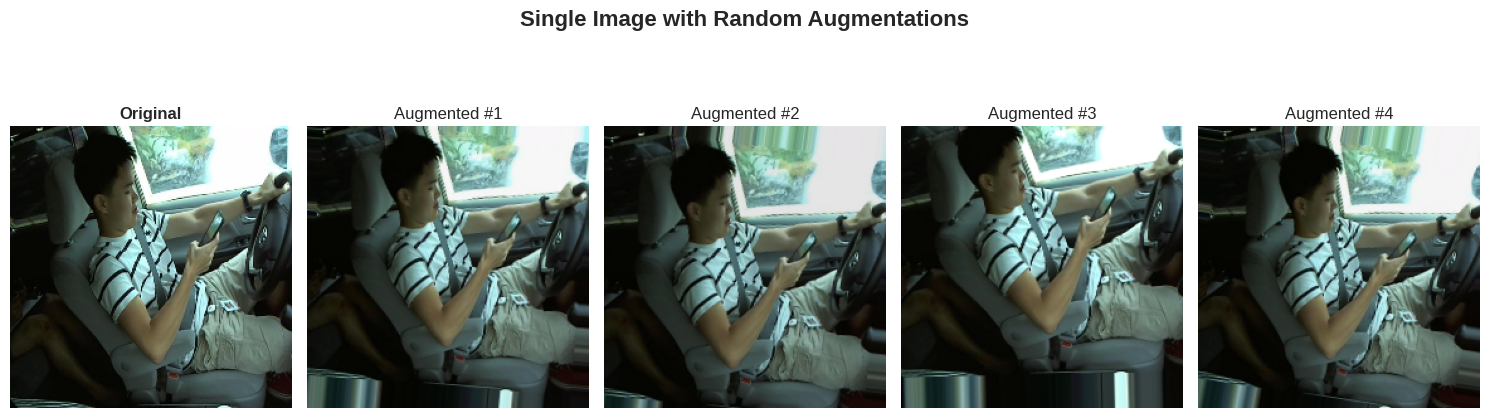

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def display_single_image_with_augmentation(image_path, num_augmentations=4):
    """
    يعرض صورة أصلية وعدة نسخ مُعدَّلة منها باستخدام ImageDataGenerator.
    """

    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(original_img, IMG_SIZE)


    img_batch = original_img.reshape((1,) + original_img.shape)


    aug_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest',
        rescale=1./255
    )


    aug_generator = aug_datagen.flow(img_batch, batch_size=1, shuffle=False)

    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 5))
    axes = axes.ravel()


    axes[0].imshow(original_img)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')


    for i in range(num_augmentations):

        augmented_img = next(aug_generator)[0]
        axes[i+1].imshow(augmented_img)
        axes[i+1].set_title(f'Augmented #{i+1}')
        axes[i+1].axis('off')

    plt.suptitle("Single Image with Random Augmentations", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


sample_row = df_drivers[df_drivers['classname'] == 'c1'].iloc[0]
sample_img_path = os.path.join(TRAIN_DIR, sample_row['classname'], sample_row['img'])

display_single_image_with_augmentation(sample_img_path, num_augmentations=4)

In [ ]:
from tensorflow.keras.utils import Sequence

class DriverLevelDataGenerator(Sequence):
    """Custom data generator that respects driver-level split"""

    def __init__(self, dataframe, batch_size=32, img_size=(224, 224),
                 augmentation=None, shuffle=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = self._generate_batch(batch_indices)
        return batch_x, batch_y

    def _generate_batch(self, batch_indices):
        batch_x = np.zeros((len(batch_indices), *self.img_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_indices), len(CLASS_NAMES)), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            row = self.dataframe.iloc[idx]
            img_path = os.path.join(TRAIN_DIR, row['classname'], row['img'])

            # Load and preprocess image
            img = preprocess_image(img_path, target_size=self.img_size, normalize=True)

            if img is not None:
                # Apply augmentation if specified
                if self.augmentation is not None:
                    img = self._apply_augmentation(img)

                batch_x[i] = img

                # One-hot encode label
                label_idx = CLASS_NAMES.index(row['classname'])
                batch_y[i, label_idx] = 1.0

        return batch_x, batch_y

    def _apply_augmentation(self, img):
        """Apply random augmentations to image"""
        img_uint8 = (img * 255).astype(np.uint8)

        # Random rotation (±10 degrees)
        if np.random.random() > 0.5:
            angle = np.random.uniform(-10, 10)
            center = (img.shape[1] // 2, img.shape[0] // 2)
            matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_uint8 = cv2.warpAffine(img_uint8, matrix, (img.shape[1], img.shape[0]))

        # Random brightness adjustment
        if np.random.random() > 0.5:
            brightness_factor = np.random.uniform(0.8, 1.2)
            img_uint8 = np.clip(img_uint8 * brightness_factor, 0, 255).astype(np.uint8)

        return img_uint8.astype(np.float32) / 255.0

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create custom generators
print("Creating custom data generators with driver-level split...")

train_gen = DriverLevelDataGenerator(
    train_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augmentation=True,
    shuffle=True
)

val_gen = DriverLevelDataGenerator(
    val_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augmentation=False,
    shuffle=False
)

print(f" Custom generators created")
print(f"Training batches per epoch: {len(train_gen)}")
print(f"Validation batches per epoch: {len(val_gen)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Creating custom data generators with driver-level split...
 Custom generators created
Training batches per epoch: 546
Validation batches per epoch: 156
Training samples: 17446
Validation samples: 4978


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def calculate_class_weights():
    """Calculate class weights to handle class imbalance"""

    # Get class distribution
    class_counts = train_df['classname'].value_counts().sort_index()

    # Calculate class weights
    class_labels = [CLASS_NAMES.index(cls) for cls in class_counts.index]
    class_weights = compute_class_weight(
        'balanced',
        classes=np.array(class_labels),
        y=[CLASS_NAMES.index(cls) for cls in train_df['classname']]
    )

    # Create class weight dictionary
    class_weight_dict = dict(zip(class_labels, class_weights))

    print("Class Distribution and Weights:")
    print("-" * 40)
    for i, (cls, count) in enumerate(class_counts.items()):
        weight = class_weight_dict[i]
        print(f"{cls} ({CLASS_DESCRIPTIONS[cls]}): {count} samples, weight: {weight:.3f}")

    return class_weight_dict

class_weights = calculate_class_weights()

Class Distribution and Weights:
----------------------------------------
c0 (Safe driving): 1925 samples, weight: 0.906
c1 (Texting - right): 1793 samples, weight: 0.973
c2 (Talking on phone - right): 1816 samples, weight: 0.961
c3 (Texting - left): 1810 samples, weight: 0.964
c4 (Talking on phone - left): 1795 samples, weight: 0.972
c5 (Operating the radio): 1786 samples, weight: 0.977
c6 (Drinking): 1795 samples, weight: 0.972
c7 (Reaching behind): 1522 samples, weight: 1.146
c8 (Hair and makeup): 1511 samples, weight: 1.155
c9 (Talking to passenger): 1693 samples, weight: 1.030


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_model(num_classes=10, input_shape=(224, 224, 3)):
    """Build EfficientNet-B0 model with transfer learning"""

    # Load pre-trained EfficientNet-B0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])

    return model, base_model

# Build the model
efficientnet_model, efficientnet_base = build_efficientnet_model()

print("EfficientNet Model Architecture:")
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
EfficientNet Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,717,741 (18.00 MB)

 Trainable params: 664,586 (2.54 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

efficientnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = efficientnet_model.fit(
    train_generator,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='model_mobile.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()
x=base_model.output
x=GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

x = Dropout(0.1)(x) # ****reduce dropout

x=Dense(1024,activation='relu')(x) #dense layer 2

x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,862,090 (22.36 MB)

 Trainable params: 5,838,154 (22.27 MB)

 Non-trainable params: 23,936 (93.50 KB)

In [ ]:
adam = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
mobilenet_model = model.fit(train_generator, callbacks=[early_stop, checkpoint] ,
                                                            epochs = 10, verbose = 1, validation_data =val_gen,class_weight=class_weights)



Epoch 1/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 391s 512ms/step - accuracy: 0.5798 - loss: 1.5266 - val_accuracy: 0.8877 - val_loss: 0.3953
Epoch 2/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 338s 481ms/step - accuracy: 0.9131 - loss: 0.3138 - val_accuracy: 0.8294 - val_loss: 0.7257
Epoch 3/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 335s 478ms/step - accuracy: 0.9339 - loss: 0.2532 - val_accuracy: 0.9713 - val_loss: 0.1148
Epoch 4/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 377s 471ms/step - accuracy: 0.9576 - loss: 0.1659 - val_accuracy: 0.9733 - val_loss: 0.1059
Epoch 5/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 335s 478ms/step - accuracy: 0.9635 - loss: 0.1460 - val_accuracy: 0.9466 - val_loss: 0.1692
Epoch 6/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 338s 482ms/step - accuracy: 0.9648 - loss: 0.1352 - val_accuracy: 0.9448 - val_loss: 0.1971
Epoch 7/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 331s 472ms/step - accuracy: 0.9679 - loss: 0.1327 - val_accuracy: 0.9793 - val_loss: 0.0692
Epoch 8/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 330s 471ms/step - accuracy: 0.9746 -

In [ ]:
import pickle

model.save('mobilenet_model.keras')
print("✅ Model saved as mobilenet_model.keras")

with open('mobilenet_history.pkl', 'wb') as f:
    pickle.dump(mobilenet_model.history, f)
print("✅ History saved as mobilenet_history.pkl")


✅ Model saved as mobilenet_model.keras
✅ History saved as mobilenet_history.pkl


In [ ]:

sgd = optimizers.SGD(learning_rate = 0.001)

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

mobilenet_model = model.fit(train_generator,steps_per_epoch = int(22000 / 64), callbacks=[early_stop, checkpoint] ,
                                                            epochs = 25, verbose = 1, validation_data =val_gen,class_weight=class_weights)



Epoch 1/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.1815 - loss: 2.6836

343/343 ━━━━━━━━━━━━━━━━━━━━ 259s 527ms/step - accuracy: 0.1817 - loss: 2.6823 - val_accuracy: 0.6559 - val_loss: 1.3296
Epoch 2/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5383 - loss: 1.3627

343/343 ━━━━━━━━━━━━━━━━━━━━ 190s 556ms/step - accuracy: 0.5384 - loss: 1.3622 - val_accuracy: 0.8495 - val_loss: 0.5970
Epoch 3/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 1:13 224ms/step - accuracy: 0.7672 - loss: 0.7528

343/343 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.7448 - loss: 0.8090 - val_accuracy: 0.8562 - val_loss: 0.5811
Epoch 4/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7624 - loss: 0.7401

343/343 ━━━━━━━━━━━━━━━━━━━━ 206s 499ms/step - accuracy: 0.7625 - loss: 0.7399 - val_accuracy: 0.9144 - val_loss: 0.3313
Epoch 5/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8448 - loss: 0.5044

343/343 ━━━━━━━━━━━━━━━━━━━━ 172s 503ms/step - accuracy: 0.8448 - loss: 0.5043 - val_accuracy: 0.9335 - val_loss: 0.2334
Epoch 6/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 1:47 327ms/step - accuracy: 0.8706 - loss: 0.3882

343/343 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.8648 - loss: 0.3923 - val_accuracy: 0.9383 - val_loss: 0.2307
Epoch 7/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8837 - loss: 0.3681

343/343 ━━━━━━━━━━━━━━━━━━━━ 174s 506ms/step - accuracy: 0.8837 - loss: 0.3680 - val_accuracy: 0.9508 - val_loss: 0.1786
Epoch 8/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9153 - loss: 0.2961

343/343 ━━━━━━━━━━━━━━━━━━━━ 171s 501ms/step - accuracy: 0.9153 - loss: 0.2961 - val_accuracy: 0.9570 - val_loss: 0.1471
Epoch 9/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 1:48 331ms/step - accuracy: 0.9135 - loss: 0.2838

343/343 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.9205 - loss: 0.2811 - val_accuracy: 0.9586 - val_loss: 0.1460
Epoch 10/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9352 - loss: 0.2382

343/343 ━━━━━━━━━━━━━━━━━━━━ 184s 503ms/step - accuracy: 0.9352 - loss: 0.2382 - val_accuracy: 0.9652 - val_loss: 0.1210
Epoch 11/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9423 - loss: 0.1963

343/343 ━━━━━━━━━━━━━━━━━━━━ 171s 500ms/step - accuracy: 0.9423 - loss: 0.1963 - val_accuracy: 0.9675 - val_loss: 0.1101
Epoch 12/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 1:45 322ms/step - accuracy: 0.9631 - loss: 0.1531

343/343 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9660 - loss: 0.1447 - val_accuracy: 0.9667 - val_loss: 0.1074
Epoch 13/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9485 - loss: 0.1823

343/343 ━━━━━━━━━━━━━━━━━━━━ 186s 499ms/step - accuracy: 0.9485 - loss: 0.1822 - val_accuracy: 0.9727 - val_loss: 0.0921
Epoch 14/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9537 - loss: 0.1522

343/343 ━━━━━━━━━━━━━━━━━━━━ 172s 502ms/step - accuracy: 0.9537 - loss: 0.1522 - val_accuracy: 0.9759 - val_loss: 0.0845
Epoch 15/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9642 - loss: 0.1154 - val_accuracy: 0.9727 - val_loss: 0.0862
Epoch 16/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9593 - loss: 0.1446

343/343 ━━━━━━━━━━━━━━━━━━━━ 173s 505ms/step - accuracy: 0.9593 - loss: 0.1446 - val_accuracy: 0.9779 - val_loss: 0.0723
Epoch 17/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9632 - loss: 0.1265

343/343 ━━━━━━━━━━━━━━━━━━━━ 171s 500ms/step - accuracy: 0.9632 - loss: 0.1265 - val_accuracy: 0.9799 - val_loss: 0.0678
Epoch 18/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.9664 - loss: 0.1352 - val_accuracy: 0.9787 - val_loss: 0.0727
Epoch 19/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9690 - loss: 0.1181

343/343 ━━━━━━━━━━━━━━━━━━━━ 170s 496ms/step - accuracy: 0.9690 - loss: 0.1181 - val_accuracy: 0.9795 - val_loss: 0.0627
Epoch 20/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9696 - loss: 0.1111

343/343 ━━━━━━━━━━━━━━━━━━━━ 169s 493ms/step - accuracy: 0.9696 - loss: 0.1111 - val_accuracy: 0.9815 - val_loss: 0.0611
Epoch 21/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 2:00 367ms/step - accuracy: 0.9607 - loss: 0.1521

343/343 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9664 - loss: 0.1356 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 22/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9732 - loss: 0.0967

343/343 ━━━━━━━━━━━━━━━━━━━━ 191s 500ms/step - accuracy: 0.9732 - loss: 0.0967 - val_accuracy: 0.9829 - val_loss: 0.0548
Epoch 23/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9706 - loss: 0.0967

343/343 ━━━━━━━━━━━━━━━━━━━━ 170s 498ms/step - accuracy: 0.9706 - loss: 0.0967 - val_accuracy: 0.9851 - val_loss: 0.0494
Epoch 24/25
 15/343 ━━━━━━━━━━━━━━━━━━━━ 1:49 335ms/step - accuracy: 0.9474 - loss: 0.1795

343/343 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9638 - loss: 0.1447 - val_accuracy: 0.9863 - val_loss: 0.0483
Epoch 25/25
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9733 - loss: 0.0922

343/343 ━━━━━━━━━━━━━━━━━━━━ 186s 494ms/step - accuracy: 0.9733 - loss: 0.0922 - val_accuracy: 0.9863 - val_loss: 0.0452


In [ ]:
import pickle

with open('mobilenet_history.pkl', 'wb') as f:
    pickle.dump(mobilenet_model.history, f)

print("History saved to mobilenet_history_sdm.pkl")


In [ ]:
model.save("mod2mobile.keras")

In [ ]:
from tensorflow.keras.applications import ResNet50
num_classes=10
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# 2. تجميد كل الطبقات في البداية
for layer in base_model.layers:
    layer.trainable = False

# 3. إضافة الطبقات المخصصة
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_resNet = Model(inputs=base_model.input, outputs=predictions)

model_resNet.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True)

# 6. التدريب المبدئي
print("Starting initial training...")
model.fit(
    train_generator,
    steps_per_epoch=int(17442 /32),
    epochs=10,
    verbose=1,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


Starting initial training...
Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.1252 - loss: 2.3104

545/545 ━━━━━━━━━━━━━━━━━━━━ 310s 552ms/step - accuracy: 0.1253 - loss: 2.3103 - val_accuracy: 0.1750 - val_loss: 2.2059
Epoch 2/10
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:51 442ms/step - accuracy: 0.1924 - loss: 2.2088

545/545 ━━━━━━━━━━━━━━━━━━━━ 89s 163ms/step - accuracy: 0.1976 - loss: 2.2063 - val_accuracy: 0.2268 - val_loss: 2.1877
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.2196 - loss: 2.1742

545/545 ━━━━━━━━━━━━━━━━━━━━ 324s 505ms/step - accuracy: 0.2196 - loss: 2.1741 - val_accuracy: 0.2730 - val_loss: 2.1059
Epoch 4/10
156/545 ━━━━━━━━━━━━━━━━━━━━ 3:03 473ms/step - accuracy: 0.2433 - loss: 2.1405

545/545 ━━━━━━━━━━━━━━━━━━━━ 115s 211ms/step - accuracy: 0.2361 - loss: 2.1354 - val_accuracy: 0.2764 - val_loss: 2.0818
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.2569 - loss: 2.1003

545/545 ━━━━━━━━━━━━━━━━━━━━ 332s 515ms/step - accuracy: 0.2569 - loss: 2.1003 - val_accuracy: 0.2519 - val_loss: 2.0709
Epoch 6/10
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:56 454ms/step - accuracy: 0.2773 - loss: 2.0721

545/545 ━━━━━━━━━━━━━━━━━━━━ 97s 178ms/step - accuracy: 0.2766 - loss: 2.0705 - val_accuracy: 0.2832 - val_loss: 2.0315
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.2809 - loss: 2.0495

545/545 ━━━━━━━━━━━━━━━━━━━━ 271s 489ms/step - accuracy: 0.2809 - loss: 2.0495 - val_accuracy: 0.3164 - val_loss: 1.9703
Epoch 8/10
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:49 436ms/step - accuracy: 0.2921 - loss: 2.0149

545/545 ━━━━━━━━━━━━━━━━━━━━ 89s 163ms/step - accuracy: 0.3007 - loss: 2.0082 - val_accuracy: 0.3570 - val_loss: 1.9673
Epoch 9/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.2989 - loss: 2.0043

545/545 ━━━━━━━━━━━━━━━━━━━━ 272s 500ms/step - accuracy: 0.2989 - loss: 2.0043 - val_accuracy: 0.3759 - val_loss: 1.8897
Epoch 10/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 89s 164ms/step - accuracy: 0.3157 - loss: 1.9771 - val_accuracy: 0.3453 - val_loss: 1.8952


In [ ]:

# 7. فتح آخر 15 طبقة فقط
for layer in base_model.layers[-15:]:
    layer.trainable = True

# 8. Compile تاني بعد الفتح
model.compile(optimizer=Adam(learning_rate=1e-5),  # Learning rate أقل
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 9. التدريب مع Fine-tuning
print(" Fine-tuning last 15 layers...")
resnet_history = model.fit(
    train_generator,
    steps_per_epoch=int(17442 / 32),
    epochs=15,
    verbose=1,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

# 10. حفظ الموديل النهائي
model.save('resnet_model_adam.h5')
print(" Final model saved as resnet_model.h5")

# 11. حفظ history
with open('resnet_history.pkl', 'wb') as f:
    pickle.dump(resnet_history.history, f)
print(" History saved as resnet_history.pkl")


 Fine-tuning last 15 layers...
Epoch 1/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3273 - loss: 1.9596

545/545 ━━━━━━━━━━━━━━━━━━━━ 283s 501ms/step - accuracy: 0.3273 - loss: 1.9595 - val_accuracy: 0.3851 - val_loss: 1.8816
Epoch 2/15
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:50 438ms/step - accuracy: 0.3281 - loss: 1.9587

545/545 ━━━━━━━━━━━━━━━━━━━━ 89s 163ms/step - accuracy: 0.3323 - loss: 1.9579 - val_accuracy: 0.3865 - val_loss: 1.8765
Epoch 3/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.3369 - loss: 1.9510

545/545 ━━━━━━━━━━━━━━━━━━━━ 286s 493ms/step - accuracy: 0.3369 - loss: 1.9510 - val_accuracy: 0.3929 - val_loss: 1.8708
Epoch 4/15
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:53 446ms/step - accuracy: 0.3291 - loss: 1.9502

545/545 ━━━━━━━━━━━━━━━━━━━━ 90s 166ms/step - accuracy: 0.3263 - loss: 1.9528 - val_accuracy: 0.3917 - val_loss: 1.8691
Epoch 5/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 270s 495ms/step - accuracy: 0.3365 - loss: 1.9519 - val_accuracy: 0.3853 - val_loss: 1.8715
Epoch 6/15
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:58 458ms/step - accuracy: 0.3357 - loss: 1.9429

545/545 ━━━━━━━━━━━━━━━━━━━━ 94s 173ms/step - accuracy: 0.3324 - loss: 1.9465 - val_accuracy: 0.4060 - val_loss: 1.8575
Epoch 7/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3461 - loss: 1.9393

545/545 ━━━━━━━━━━━━━━━━━━━━ 286s 492ms/step - accuracy: 0.3460 - loss: 1.9393 - val_accuracy: 0.3998 - val_loss: 1.8547
Epoch 8/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 90s 166ms/step - accuracy: 0.3502 - loss: 1.9241 - val_accuracy: 0.3947 - val_loss: 1.8554
Epoch 9/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.3473 - loss: 1.9381

545/545 ━━━━━━━━━━━━━━━━━━━━ 269s 493ms/step - accuracy: 0.3473 - loss: 1.9381 - val_accuracy: 0.4048 - val_loss: 1.8518
Epoch 10/15
156/545 ━━━━━━━━━━━━━━━━━━━━ 2:53 446ms/step - accuracy: 0.3366 - loss: 1.9259

545/545 ━━━━━━━━━━━━━━━━━━━━ 94s 172ms/step - accuracy: 0.3369 - loss: 1.9268 - val_accuracy: 0.4048 - val_loss: 1.8510
Epoch 11/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3410 - loss: 1.9325

545/545 ━━━━━━━━━━━━━━━━━━━━ 266s 488ms/step - accuracy: 0.3410 - loss: 1.9325 - val_accuracy: 0.4148 - val_loss: 1.8400
Epoch 12/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 88s 161ms/step - accuracy: 0.3423 - loss: 1.9222 - val_accuracy: 0.4078 - val_loss: 1.8421
Epoch 13/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.3537 - loss: 1.9209

545/545 ━━━━━━━━━━━━━━━━━━━━ 264s 485ms/step - accuracy: 0.3537 - loss: 1.9210 - val_accuracy: 0.4221 - val_loss: 1.8268
Epoch 14/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 88s 162ms/step - accuracy: 0.3424 - loss: 1.9343 - val_accuracy: 0.4066 - val_loss: 1.8360
Epoch 15/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.3510 - loss: 1.9190

545/545 ━━━━━━━━━━━━━━━━━━━━ 293s 483ms/step - accuracy: 0.3510 - loss: 1.9190 - val_accuracy: 0.4227 - val_loss: 1.8265


 Final model saved as resnet_model.h5
 History saved as resnet_history.pkl
